In [1]:
import pandas as pd
import urllib
import json
import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Problem Description
The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil.  From the analysis of the information, answer the following questions:

* Who are these customers?
* How would you classify them?
* What would be a possible CRM campaign strategy?

**Data Diagram:**

<img src="https://i.imgur.com/HRhd2Y0.png" width=760 height=760 />


<a id='data_analysis'></a>
## Data Analysis

In [2]:
customers = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv')
geolocation = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv')
orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
order_items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')

<a id='customers'></a>
### Customers

In [3]:
customers.sample(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
76631,73c2d0df55f8431aa5ec63d4e3b7bb63,aa873afe20fc222379673c8b6bcbac45,37653,monte verde,MG
25377,f9913bc021d14fc9e5a96b3508284589,341c1bfcce15f772ef1c1e93dc360141,2050,sao paulo,SP
24148,91e69f300d02ffb32f57621542b728c7,41b75c0712e41a7c79c204158ee83f72,13632,pirassununga,SP
77825,726f28d51b162c746e14553241df9de8,b7d12dd279b98c2d0f8b920052eb2862,13232,campo limpo paulista,SP
22165,50202490acea34225b1af5cdd25f4326,3be6f224efc657da0b17bf5d287c20eb,12214,sao jose dos campos,SP


check for NULL entries.

In [4]:
customers.isna().mean()

customer_id                 0.0
customer_unique_id          0.0
customer_zip_code_prefix    0.0
customer_city               0.0
customer_state              0.0
dtype: float64

There are duplicate customer_unique_id, because the dataset is per order. Where client_id is the key to the order dataset. Each order has a unique client_id.

In [5]:
customers.groupby('customer_unique_id').size().sort_values(ascending=False)

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
6469f99c1f9dfae7733b25662e7f1782     7
ca77025e7201e3b30c44b472ff346268     7
1b6c7548a2a1f9037c1fd3ddfed95f33     7
                                    ..
5657dfebff5868c4dc7e8355fea865c4     1
5657596addb4d7b07b32cd330614bdf8     1
5656eb169546146caeab56c3ffc3d268     1
5656a8fabc8629ff96b2bc14f8c09a27     1
ffffd2657e2aad2907e67c3e9daecbeb     1
Length: 96096, dtype: int64

**Geolocation:**

In [6]:
geolocation.sample(5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
811233,76340,-15.354233,-49.700578,carmo do rio verde,GO
463226,23087,-22.888432,-43.559825,rio de janeiro,RJ
914321,88519,-27.777300,-50.304584,lages,SC
45103,3152,-23.593473,-46.580962,sao paulo,SP
696133,46205,-14.548651,-41.938645,guajeru,BA


There are no null values for geolocation

In [7]:
geolocation.isna().mean()

geolocation_zip_code_prefix    0.0
geolocation_lat                0.0
geolocation_lng                0.0
geolocation_city               0.0
geolocation_state              0.0
dtype: float64

As we can see, there are duplicates of the city with accents in the names.

In [8]:
geolocation['geolocation_city'].unique()

array(['sao paulo', 'são paulo', 'sao bernardo do campo', ..., 'ciríaco',
       'estação', 'vila lângaro'], dtype=object)

In [9]:
def pretty_string(column):
    column_space = ' '.join(column.split())
    return unidecode.unidecode(column_space.lower())

In [10]:
geolocation['geolocation_city'] = geolocation['geolocation_city'].apply(pretty_string)

As we can see, there is the same zip code prefix with more than 1 location. This problem may have occurred because only the zip code prefix was kept. To solve this problem we will use the median value of the latitude and longitude of each point

In [11]:
geolocation.groupby('geolocation_zip_code_prefix').size().sort_values(ascending=False)

geolocation_zip_code_prefix
24220    1146
24230    1102
38400     965
35500     907
11680     879
         ... 
20056       1
76370       1
63012       1
76372       1
32635       1
Length: 19015, dtype: int64

In [12]:
geolocation[geolocation['geolocation_zip_code_prefix'] == 24220].head()    

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
470805,24220,-22.905817,-43.106989,niteroi,RJ
470811,24220,-22.902306,-43.112545,niteroi,RJ
470812,24220,-22.904567,-43.110491,niteroi,RJ
470820,24220,-22.902575,-43.109192,niteroi,RJ
470821,24220,-22.907500,-43.106170,niteroi,RJ


There are 8 zip codes with two or more states. To solve this problem, we will count the states by zip code and use the majority state for this zip code.

In [13]:
other_state_geolocation = geolocation.groupby(['geolocation_zip_code_prefix'])['geolocation_state'].nunique().reset_index(name='count')
other_state_geolocation[other_state_geolocation['count']>= 2].shape
max_state = geolocation.groupby(['geolocation_zip_code_prefix','geolocation_state']).size().reset_index(name='count').drop_duplicates(subset = 'geolocation_zip_code_prefix').drop('count',axis=1)

In [14]:
geolocation_silver = geolocation.groupby(['geolocation_zip_code_prefix','geolocation_city','geolocation_state'])[['geolocation_lat','geolocation_lng']].median().reset_index()
geolocation_silver = geolocation_silver.merge(max_state,on=['geolocation_zip_code_prefix','geolocation_state'],how='inner')

In [15]:
customers_silver = customers.merge(geolocation_silver,left_on='customer_zip_code_prefix',right_on='geolocation_zip_code_prefix',how='inner')

<a id='orders'></a>
## Orders

In [16]:
order_items.sample(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
70075,9fe33416283b9bfb49fcdea66c415777,1,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,2018-01-17 22:29:45,179.00,51.12
6303,0e578caa492e82502cbc4abe275042a2,1,44feb28a74abb0f2f303412d60160750,72bc2cce903c872fe376a8faaa81d237,2018-08-14 17:30:27,159.00,19.21
63992,922a3f761407bb26eca665bf67d18744,1,b804bd070b03e990e6db597e36634cdd,1cbd50a8c52e6cf8e315c5709fab386f,2018-03-12 03:49:00,19.80,34.15
52281,770ad5eec9763dbf6201f544768ed27b,1,90887320b08d184abea26df9426a01e9,0b35c634521043bf4b47e21547b99ab5,2018-03-07 20:50:31,49.99,16.93
18891,2b6908be5cc36a149ec9cb0bcdaf3866,1,e357a8646a17191f03fd9f833a0fa29b,98115075dd26cb8835946fc6086f5d30,2018-04-20 00:13:18,98.99,9.05


There are no null values for order_items

In [17]:
order_items.isna().mean()

order_id               0.0
order_item_id          0.0
product_id             0.0
seller_id              0.0
shipping_limit_date    0.0
price                  0.0
freight_value          0.0
dtype: float64

As we can see, an order can have more than one product.

In [18]:
order_items.groupby('order_id').size().sort_values(ascending=False)

order_id
8272b63d03f5f79c56e9e4120aec44ef    21
1b15974a0141d54e36626dca3fdc731a    20
ab14fdcfbe524636d65ee38360e22ce8    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
                                    ..
5a0911d70c1f85d3bed0df1bf693a6dd     1
5a082b558a3798d3e36d93bfa8ca1eae     1
5a07264682e0b8fbb3f166edbbffc6e8     1
5a071192a28951b76774e5a760c8c9b7     1
fffe41c64501cc87c801fd61db3f6244     1
Length: 98666, dtype: int64

Since we have more than 1 product per order, we need to sum the price and the shipping value and get the maximum value of the shipping_limit_date for analysis.

In [19]:
order_items_silver = order_items.groupby('order_id').agg({'price':sum,'freight_value':sum,'shipping_limit_date':max }).reset_index()

As you can see, we have some outliers. how come the shipping is over R\\$ 500 and which order costs over R\\$4000?

<AxesSubplot:xlabel='price', ylabel='freight_value'>

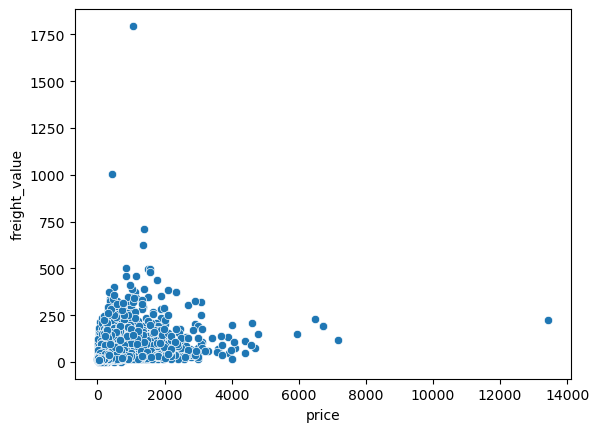

In [20]:
sns.scatterplot(x='price',y='freight_value',data=order_items_silver)

We decided to remove orders with a price over R$ 5000 and for the freight value we used logic as a value that is far away from 99% percentile.

In [21]:
order_items_silver.describe()

,price,freight_value
count,98666.000000,98666.000000
mean,137.754076,22.823562
std,210.645145,21.650909
min,0.850000,0.000000
25%,45.900000,13.850000
50%,86.900000,17.170000
75%,149.900000,24.040000
max,13440.000000,1794.960000


In [22]:
percentil_freight_value = order_items_silver['freight_value'].quantile(0.99)
order_items_silver = order_items_silver[(order_items_silver['price'] <= 5000) & (order_items_silver['freight_value'] <= percentil_freight_value)]

 As we can see, the average order price is R\\$ 132 and 50% of orders cost less than R\\$85. The average freight value is R\\$21.41 and 50% of the orders have a freight value of R\\$ 17.

In [23]:
order_items_silver.describe()

,price,freight_value
count,97679.000000,97679.000000
mean,132.046700,21.423227
std,185.015685,14.133667
min,0.850000,0.000000
25%,45.900000,13.790000
50%,85.000000,17.070000
75%,149.900000,23.700000
max,4690.000000,104.980000


In [24]:
order_items_silver

,order_id,price,freight_value,shipping_limit_date
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,2017-09-19 09:45:35
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,2017-05-03 11:05:13
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,2018-01-18 14:48:30
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,2018-08-15 10:10:18
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,2017-02-13 13:57:51
...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.41,2018-05-02 04:11:01
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53,2018-07-20 04:31:48
98663,fffce4705a9662cd70adb13d4a31832d,99.90,16.95,2017-10-30 17:14:25
98664,fffe18544ffabc95dfada21779c9644f,55.99,8.72,2017-08-21 00:04:32


In [25]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [26]:
columns_timestamp = ['order_purchase_timestamp','order_approved_at',
                     'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for column in columns_timestamp:
    orders[column] = pd.to_datetime(orders[column])

In [27]:
orders['diff_delivery_days'] = (orders['order_estimated_delivery_date'] - orders['order_delivered_customer_date']).dt.days

Only 7,87% is above of estimated delivery

In [28]:
orders.groupby(orders['diff_delivery_days'] < 0).size()

diff_delivery_days
False    91614
True      7827
dtype: int64

As we can see, the average difference between the estimated delivery and the actual delivery is 10 days, which is a bit high. Another fact is that an order was delivery 6 month later and other order was a high estimated date.

<AxesSubplot:xlabel='diff_delivery_days', ylabel='Count'>

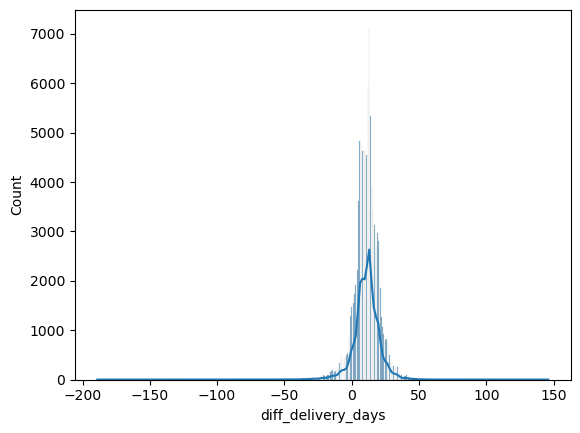

In [29]:
# print(orders['diff_delivery_days'].describe())
sns.histplot(x='diff_delivery_days', data=orders, kde=True)

We will remove the max and min value of difference.

In [30]:
orders[(orders['diff_delivery_days'] > min(orders['diff_delivery_days'])) & (orders['diff_delivery_days'] < max(orders['diff_delivery_days']))]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_delivery_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,5.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,17.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,12.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,9.0
...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,10.0
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,5.0
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,20.0


In [31]:
orders_silver = orders.merge(order_items_silver,on='order_id',how='inner')

In [32]:
def plot_ts_decompose(decompose,figsize=(12,8)):
    fig, ax = plt.subplots(4,1,figsize=figsize)
    sns.lineplot(data=decompose.observed,x=decompose.observed.index,y=decompose.observed,ax=ax[0])
    sns.lineplot(data=decompose.trend,x=decompose.trend.index,y=decompose.trend,ax=ax[1])
    sns.lineplot(data=decompose.seasonal,x=decompose.seasonal.index,y=decompose.seasonal,ax=ax[2])
    sns.lineplot(data=decompose.resid,x=decompose.resid.index,y=decompose.resid,ax=ax[3])
    plt.tight_layout()

As we can see, there is a seasonality in the series in which in the months of December there is a drop in the purchase of products and in the months of January, March, and May there is an increase. Other fact the series is a trend to incresing.

month_year_purchase
2016-10-01     304
2018-03-01    7096
2017-06-01    3196
2016-09-01       3
2017-03-01    2615
dtype: int64


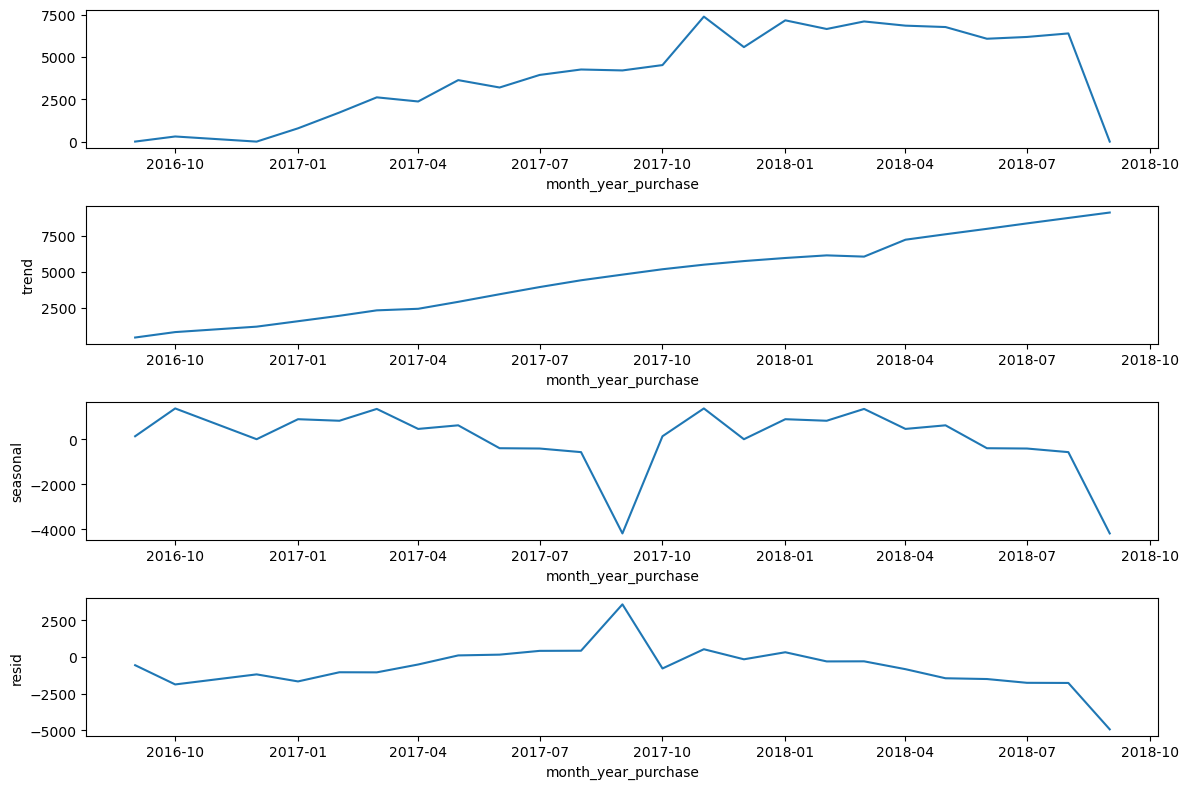

In [33]:
orders_silver['month_year_purchase'] = orders_silver['order_purchase_timestamp'].dt.to_period('M')
order_purchase_timestamp = orders_silver.groupby('month_year_purchase').size()
order_purchase_timestamp.index = order_purchase_timestamp.index.astype('datetime64[ns]')
print(order_purchase_timestamp.sample(5))
decompose = seasonal_decompose(order_purchase_timestamp,model='additive',period=12, extrapolate_trend=12)
plot_ts_decompose(decompose)

In [34]:
orders_customers = customers.merge(orders_silver, on='customer_id', how='inner')

In [35]:
max_date = max(orders_customers['order_purchase_timestamp']) + datetime.timedelta(days=1)

In [36]:
rfm_data = orders_customers.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (max_date - x.max()).days,
    'customer_id':'count',
    'price':'sum'
}).reset_index()
rfm_data.columns =['customer_id','recency','frequency','monetary']

Note that the frequency of customers is the big problem for the classification, because only 3% of customers made more than one purchase but is something that's very common in ecommerce.

0.03034247735162137
count    94488.000000
mean         1.033771
std          0.210110
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: frequency, dtype: float64


<AxesSubplot:xlabel='frequency', ylabel='Count'>

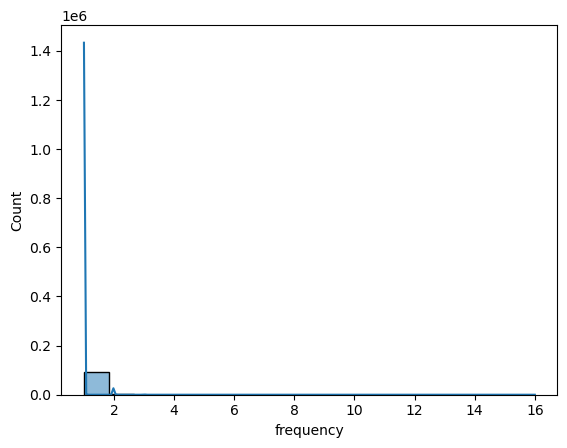

In [37]:
print(rfm_data[rfm_data['frequency']>1].shape[0] / rfm_data.shape[0])
print(rfm_data['frequency'].describe())
sns.histplot(x='frequency', data=rfm_data, kde=True)

An average monetary customer is R\\$136 and 75% of the customers spend less than R\\$150 and the maximum was R\\$4690.

count    94488.000000
mean       136.506113
std        190.946953
min          0.850000
25%         47.000000
50%         89.000000
75%        150.000000
max       4690.000000
Name: monetary, dtype: float64


<AxesSubplot:xlabel='monetary', ylabel='Count'>

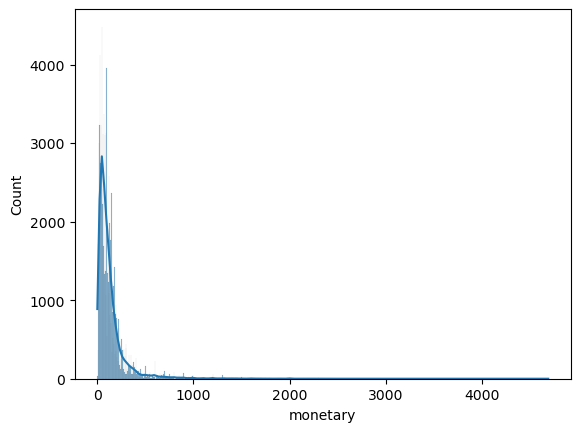

In [38]:
print(rfm_data['monetary'].describe())
sns.histplot(x='monetary', data=rfm_data, kde=True)

As we can see the 25% of customers have a recency of 3.9 months with an average of 8 months. With a purchase frequency equivalent to 1 and with this recency this indicates that customers make very specific purchases.

count    94488.000000
mean       243.851198
std        153.165787
min          1.000000
25%        120.000000
50%        224.000000
75%        353.000000
max        729.000000
Name: recency, dtype: float64


<AxesSubplot:xlabel='recency', ylabel='Count'>

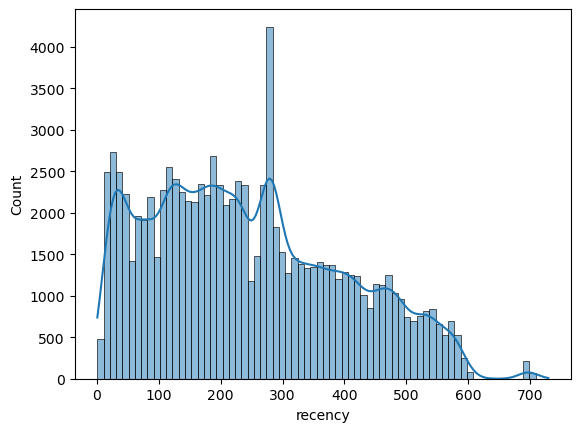

In [39]:
print(rfm_data['recency'].describe())
sns.histplot(x='recency', data=rfm_data, kde=True)

<a id='data_insights'></a>

**Conclusions:**
* There are more customers in the southeast and south of the country. Other information, there are more customers in cities that are capitals (São Paulo, Rio de Janeiro, Porto Alegre and otheres);
* The average order price is R\\$ 132 and 50% of orders cost less than R\\$85. The average freight value is R\\$21.41 and 50% of the orders have a freight value of R\\$ 17;
* The delivery date needs to be revised because the average difference between estimated and actual delivery is 10 days, which is a bit high. Another fact is that only 7.81% of the actual delivery was lower than the estimated delivery;
* There is a seasonal buying series in which in the months of December there is a drop in the purchase of products and in the months of January, March and May there is an increase;
* Only 3% of customers made more than one purchase;
* An average monetary customer is R\\$136 and 75% of the customers spend less than R\\$150 and the maximum was R\\$4690;
* The 25% of customers have a recency of 3.9 months with an average of 8 months. With a purchase frequency equivalent to 1 and with this recency this indicates that customers make very specific purchases.

<a id='customer_segmentation'></a>
## Customer Segmentation

As a algorithm the RFM was used, for being an easy-to-understand model.

<a id='rfm'></a>
The term RFM comes from the junction of three acronyms: Recency, Frequency, and Monetarity, seeking to better understand the customer and verify when was his last purchase, how many times he has bought and how much he has spent with the company.

Recency(R) Days since the customer's last purchase
Frequency(F) Number of products bought by the customer
Monetarity(M) Total spent on purchases

Customer Score:

The customer score ranges from 1 to 5, where the higher this number, the better. This score is assigned for each acronym independently:

* The more recent the customer's purchase the higher the Recency (R) score.
* The more purchases the customer makes, the higher the Frequency score (F)
* The more the customer spends on purchases, the higher the score the customer will have Monetarity(M)

This definition of each score can be given through inference, i.e. some business definition or by quintile.


#### Segmentation calculation:

The calculation to know which segmentation the customer is in is given by averaging the F and M scores and the separate R value.

| Segment Name               | Range of R values | Range of F and M Average |
|----------------------------|-------------------|--------------------------|
| Champions                  |       4 - 5       |           4 - 5          |
| Loyal Customers            |       2 - 5       |           3 - 5          |
| Potential Loyalist         |       3 - 5       |           1 - 3          |
| New Customers              |       4 - 5       |           0 - 1          |
| Promising                  |       3 - 4       |           0 - 1          |
| Customers Needing Attetion |       2 - 3       |           2 - 3          |
| About to Sleep             |       2 - 3       |           0 - 2          |
| At Risk                    |       0 - 2       |           2 - 5          |
| Can't Lose Them            |       0 - 1       |           4 - 5          |
| Hibernating                |       1 - 2       |           1 - 2          |
| Lost                       |       0 - 2       |           0 - 2          |

We have only 3% of customers who have made more than one purchase, i.e., we have skewed data. For this problem, we use the k-means algorithm to group the data according to their similar characteristics.

In [40]:
def k_means_group(data, n_clusters, random_state, asc=False, log_transf=False, standard_tranf=False):
    
    data_temp = data.copy()
    if log_transf:
        data_temp = np.log(data_temp) + 1
        
    if standard_tranf:
        scaler = StandardScaler()
        scaler = scaler.fit(data_temp)
        data_temp = scaler.transform(data_temp)
        
    kmeans_sel = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data_temp)
    cluster_group = data.assign(cluster = kmeans_sel.labels_)
    mean_group = cluster_group.groupby('cluster').mean().reset_index()
    mean_group = mean_group.sort_values(by=mean_group.columns[1],ascending=asc)
    mean_group['cluster_set'] = [i for i in range(n_clusters, 0, -1) ]
    cluster_map = mean_group.set_index('cluster').to_dict()['cluster_set']
    return cluster_group['cluster'].map(cluster_map)

In [41]:
r_labels = k_means_group(rfm_data[['recency']],6,1,asc=True)
f_labels = k_means_group(rfm_data[['frequency']],6,1)
m_labels = k_means_group(rfm_data[['monetary']],6,1)
rfm_data = rfm_data.assign(R = r_labels, F = f_labels, M = m_labels) 

In [42]:
rfm_data['R'] = rfm_data['R'] - 1
rfm_data['R'] = rfm_data['F'] - 1
rfm_data['R'] = rfm_data['M'] - 1

As we can see, most customers have a recency between 5 to 8 months.

In [43]:
rfm_data.groupby('R')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
R,,,,,,,,
0,55396.0,246.577370,153.801551,5.0,122.0,229.0,357.0,729.0
1,27899.0,236.762214,150.793461,5.0,117.0,215.0,341.0,718.0
2,7921.0,249.164121,154.831445,1.0,124.0,230.0,355.0,699.0
3,2383.0,243.666807,155.642375,6.0,118.0,219.0,347.0,699.0
4,709.0,249.571227,153.109870,9.0,124.0,235.0,364.0,698.0
5,180.0,249.722222,178.185393,9.0,95.0,212.0,439.5,584.0


 Because only 3% of customers made more than one purchase but is something that's very common in ecommerce.

In [44]:
rfm_data.groupby('F')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
F,,,,,,,,
1,91621.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
2,2633.0,2.000000,0.000000,2.0,2.0,2.0,2.00,2.0
3,187.0,3.000000,0.000000,3.0,3.0,3.0,3.00,3.0
4,38.0,4.263158,0.446258,4.0,4.0,4.0,4.75,5.0
5,8.0,6.625000,1.060660,6.0,6.0,6.0,7.00,9.0
6,1.0,16.000000,NaN,16.0,16.0,16.0,16.00,16.0


As we can see, most customers have an average monetary value of R\$ 58.29. Which is not very good for business because the bigger the better.

In [45]:
rfm_data.groupby('M')['monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
M,,,,,,,,
1,55396.0,54.184579,26.234024,0.85,30.00,50.000,75.00,104.99
2,27899.0,155.035122,36.563567,105.00,122.99,149.000,179.96,244.08
3,7921.0,332.783065,68.170208,244.50,278.00,319.800,379.80,503.34
4,2383.0,673.861490,121.762913,504.00,578.00,649.000,759.99,970.00
5,709.0,1270.496178,229.348784,975.00,1094.04,1200.000,1399.99,1820.00
6,180.0,2381.596722,593.458494,1828.44,1999.00,2134.995,2649.00,4690.00


In [46]:
def get_segment(data):
    mean_fm = (data['F'] + data['M']) / 2
    
    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 4 and mean_fm <= 5):
        return 'Champions'
    if (data['R'] >= 2 and data['R'] <= 5) and (mean_fm >= 3 and mean_fm <= 5):
        return 'Loyal Customers'
    if (data['R'] >= 3 and data['R'] <= 5) and (mean_fm >= 1 and mean_fm <= 3):
        return 'Potential Loyslist'
    if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 0 and mean_fm <= 1):
        return 'New Customers'
    if (data['R'] >= 3 and data['R'] <= 4) and (mean_fm >= 0 and mean_fm <= 1):
        return 'Promising'
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 2 and mean_fm <= 3):
        return 'Customer Needing Attention'
    if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 0 and mean_fm <= 2):
        return 'About to Sleep'
    if (data['R'] >= 0 and data['R'] <= 2) and (mean_fm >= 2 and mean_fm <= 5):
        return 'At Risk'
    if (data['R'] >= 0 and data['R'] <= 1) and (mean_fm >= 4 and mean_fm <= 5):
        return "Can't Lose Then"
    if (data['R'] >= 1 and data['R'] <= 2) and (mean_fm >= 1 and mean_fm <= 2):
        return 'Hibernating'
    return 'Lost'

In [47]:
rfm_data['segment'] = rfm_data.apply(get_segment,axis=1)

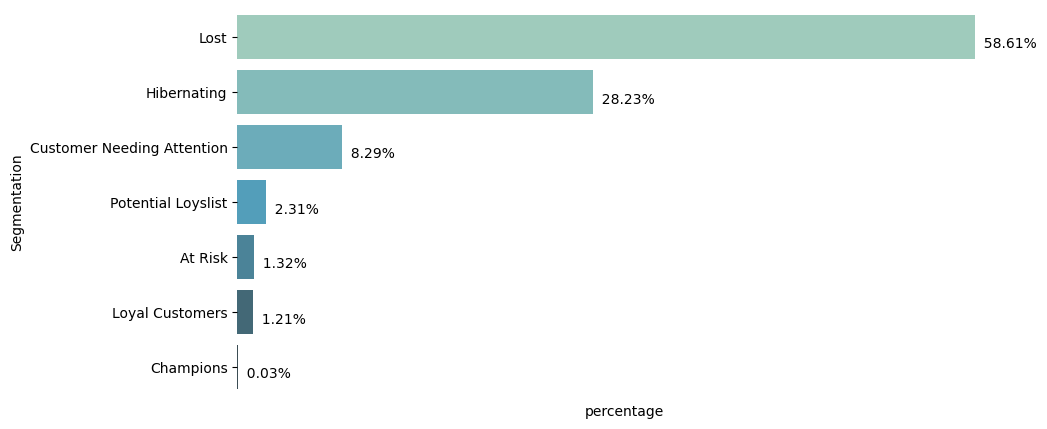

In [48]:
plt.figure(figsize=(10,5))
percentage = (rfm_data['segment'].value_counts(normalize=True)* 100).reset_index(name='percentage')
g = sns.barplot(x=percentage['percentage'],y=percentage['index'], data=percentage,palette="GnBu_d")
sns.despine(bottom = True, left = True)
for i, v in enumerate(percentage['percentage']):
    g.text(v,i+0.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
g.set_ylabel('Segmentation')
g.set(xticks=[])
plt.show()

### Conclusion:

**58.61% - Lost:**

Low frequency of purchase, recency and spending.

<u>CRM Strategy:</u>

* Reviving interest with outreach campaigns

**28.23% - Hibernating:**

These are customers who have bought a long time ago, only a few times and have spent little

<u>CRM Strategy</u>:

* Standard communication for sending offers;
* Offer relevant products and good deals.

**8.29% - Customer Needing Attetion:**

These are customers who have recently purchased, however are still in doubt whether they will make their next purchase from the company or a competitor.

<u>CRM Strategy</u>:

* Promotional campaigns for a limited time;
* Product recommendations based on their behavior;
* Show the importance of buying with the company.

**2.31% - Potential Loyslist:**

These are recent buyers, spend a good amount and have bought more than once.

<u>CRM Strategy</u>:

* Offer a loyalty program;
* Keep them engaged;
* Personalized and other product recommendations.

**1.32% - At Risk:**

These are customers who have spent very little money and buy frequently, but have not bought for a long time

<u>CRM Strategy</u>:

* Send personalized communications and other messages to reconnect;
* Offer good deals.

**1.21% - Loyal Customers:**

These are customers who spend well and often.

<u>CRM Strategy</u>:

* Personalized communication;
* Avoid mass mailing of offers;
* Offer few products, but present products that they are likely to be interested in;
* Ask for product reviews.

**0.03% - Champions:**

These are customers who have bought recently, buy often, and spend a lot.

<u> CRM Strategy</u>:

* Special offers, products and discounts for these customers so they feel valued;
* Ask for reviews and feedbacks constantly;
* Avoid sending massive amounts of offers;
* Personalized communication;
* Give rewards.